__Purpose__ : Clean my friend Jamie's data and deconvolute the Shewanella oneidensis genomic reads from their own DNA, which contaminated the run. 


First, I ran the following command on the PuTTY terminal. The following command submits the sequencing reads (illumina_reads.fastq) to a human genome database (hg19) and obtains unaligned reads as unaligned.fastq. __The reads left unaligned to the human genome ( in unaligned.fastq) will contain the Shewanella oneidensis reads.__ 

In [ ]:
bowtie2 -p 4 --very-fast --no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq -S output1.sam --un unaligned.fastq


The following output was generated: 

1124714 reads; of these:
  1124714 (100.00%) were unpaired; of these:
    1028379 (91.43%) aligned 0 times
    87274 (7.76%) aligned exactly 1 time
    9061 (0.81%) aligned >1 times
8.57% overall alignment rate


__8.57% of my sequencing library came from contaminating human DNA.__ 

In order to determine the quality of the reads, I ran bowtie2 again using the filtered reads that did not align to the human genome (presumably Shewanella oneidensis DNA) as my input reads and the Shewanella oneidensis genome as the reference. I used the following command in the PuTTY terminal: 

In [ ]:
bowtie2 -p 4 --very-fast --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U unaligned.fastq -S output_filtered.sam --un unaligned2.fastq

The following output was generated: 

1028379 reads; of these:
  1028379 (100.00%) were unpaired; of these:
    299560 (29.13%) aligned 0 times
    687571 (66.86%) aligned exactly 1 time
    41248 (4.01%) aligned >1 times
70.87% overall alignment rate

    
__Here, 'unaligned2.fastq' will contain sequences that neither aligned with the human genome or the Shewanella oneidensis genome. 29.13% of the reads did not allign to the reference genome. This may include low quality reads or additional contamination from other organisms. __

__When '--very-sensitive' was used instead of '--very-fast' (command shown below), the following output was generated:__

1028379 reads; of these:
  1028379 (100.00%) were unpaired; of these:
    298112 (28.99%) aligned 0 times
    688180 (66.92%) aligned exactly 1 time
    42087 (4.09%) aligned >1 times
71.01% overall alignment rate

__As seen, the overall alignment rate improved by 0.14%.__





In [ ]:
bowtie2 -p 4 --very-sensitive --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U unaligned.fastq -S output_senstitivefiltered.sam --un unaligned2sensitive.fastq


__The following commands were used to generate the 'sensitive.tab' file.__

__Converting sam file to bam files__

In [ ]:
samtools view -b output_senstitivefiltered.sam >output_sens.bam

__Sorting the bam file__

In [ ]:
samtools sort output_sens.bam > output_sens.sorted.bam

__Indexing the bam file__

In [ ]:
samtools index output_sens.sorted.bam

__Generating a tab separated file for iterating through in python__

In [ ]:
samtools depth -a output_sens.sorted.bam > sensitive.tab

The code below imports matplotlib.pyplot and numpy in order to generate plots of the coverage data processed using the commands above. 

'positions' and 'coverages' are defined as empty lists to be populated later. 'depths' is the variable name of the tab file containing the depth of sequencing at each position using the '--very-sensitive' method with bowtie2. 

For each row in the tab separated file, a tab-separated list 'tab_delimited_info' is generated. The second entry in each of these temporary lists will contain the position. The third entry in each of these temporary lists will contain the coverage as a string along with a '\n' at the end. To get rid of the '\n', I simply take the third entry of 'tab_delimited_info' and split it at '\n', taking the first entry of the resulting list 'coverage_no_line' as calling it 'coverage'. Then, I add the cleaned coverages and positions to the 'positions' and 'coverages' lists defined earlier. 

To generated lists of integers that can be ploted with pyplot, I simply iterate through positions and coverages, casting each entry in the list as an integer and adding it to a final duo of lists position_coord and coverage_coord. 

In [30]:
import matplotlib.pyplot as plt
import numpy as np

positions = []
coverages = []
depths = open('sensitive.tab')


for entry in depths:
    tab_delimited_info = entry.split('\t')
    
    coverage_no_line = tab_delimited_info[2].split('\n')
    coverage = coverage_no_line[0]
    
    positions.append(tab_delimited_info[1])
    coverages.append(coverage)
    
position_coord = []
coverage_coord = []

for i in range(len(positions)):
    position_coord.append(int(positions[i]))
    if len(positions)==len(coverages):
        coverage_coord.append(int(coverages[i]))


Plotting the coverage at each position. 

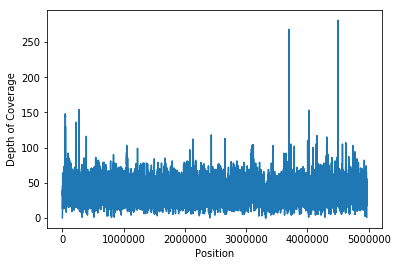

In [31]:
plt.plot(position_coord, coverage_coord)
plt.xlabel('Position')
plt.ylabel('Depth of Coverage')
plt.show()


Plotting the histogram of coverages within the set of reads. 

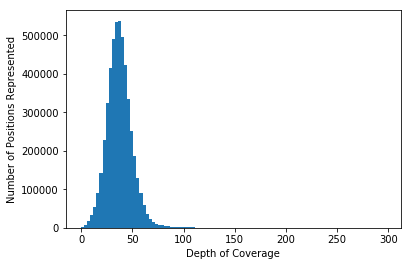

In [34]:
plt.hist(coverage_coord, bins = range(0,300, 3))
plt.xlabel('Depth of Coverage')
plt.ylabel('Number of Positions Represented')
plt.show()


In [35]:
min_coverage = min(coverage_coord)
max_coverage = max(coverage_coord)
average_coverage = np.average(coverage_coord)
print(min_coverage)
print(max_coverage)
print(average_coverage)

0
281
37.03830306625343


__Analysis__

The minimum coverage is 0, maximum coverage is 281. The average coverage is 37.038. 

KeyboardInterrupt: 